In [37]:
import numpy as np
import tensorflow as tf
import keras

import cv2
from keras.layers import MaxPool2D, Conv2D, UpSampling2D, Input, Dropout, Flatten, Dense
from keras.models import Sequential
#from keras.proprocessing.image import img_to_array
from keras.utils import img_to_array, to_categorical
import os
import tqdm
import re
import matplotlib.pyplot as plt

from skimage import color

In [138]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Cargamos el Dataset

In [171]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [172]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [201]:
x_train.shape

(50000, 32, 32, 3)

### Visualizar el dataset

In [173]:
def plot_images(color, grayscale):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1, 3, 2)
    plt.title("Grayscale Image", color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')
    plt.show()

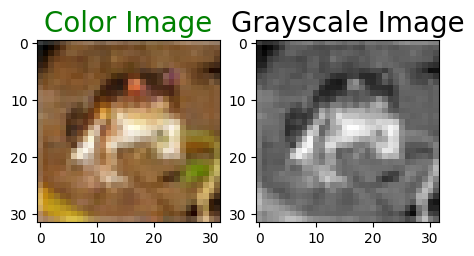

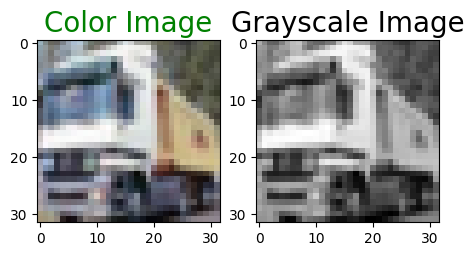

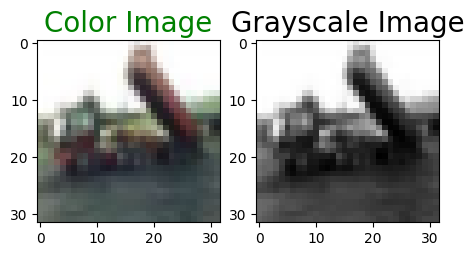

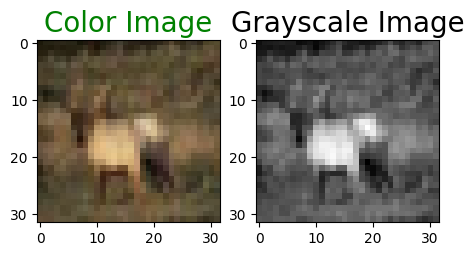

In [174]:
for i in range(4):
    plot_images(x_train[i], color.rgb2gray(x_train[i]))

### Conversión de los datos

In [175]:
from sklearn.model_selection import train_test_split
from skimage import color

In [176]:
# Pasamos a blanco y negro
x_train_gray = color.rgb2gray(x_train)
x_test_gray = color.rgb2gray(x_test)

# Aplanar las imágenes
x_train_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_flat = x_test_gray.reshape(x_test_gray.shape[0], -1)

In [177]:
# Normlización
x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0

In [178]:
# One hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

# Train - Validation
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_flat, y_train_one_hot, test_size=0.2, random_state=42
)

### MLP

In [179]:
# Modelo MLP
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(32 * 32,), name='input_layer'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax', name='output_layer')
])

In [180]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 128)               131200    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 140106 (547.29 KB)
Trainable params: 140106 (547.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
history = model.fit(
    x_train_split, y_train_split,
    epochs=60,
    batch_size=32,
    validation_data=(x_val_split, y_val_split)
)

Epoch 1/60
1250/1250 [==============================] - 1s 879us/step - loss: 2.2218 - accuracy: 0.1615 - val_loss: 2.1302 - val_accuracy: 0.2225
Epoch 2/60
1250/1250 [==============================] - 1s 846us/step - loss: 2.1267 - accuracy: 0.2100 - val_loss: 2.0870 - val_accuracy: 0.2377
Epoch 3/60
1250/1250 [==============================] - 1s 844us/step - loss: 2.0962 - accuracy: 0.2264 - val_loss: 2.0563 - val_accuracy: 0.2545
Epoch 4/60
1250/1250 [==============================] - 1s 1ms/step - loss: 2.0770 - accuracy: 0.2400 - val_loss: 2.0295 - val_accuracy: 0.2704
Epoch 5/60
1250/1250 [==============================] - 2s 1ms/step - loss: 2.0608 - accuracy: 0.2493 - val_loss: 2.0157 - val_accuracy: 0.2789
Epoch 6/60
1250/1250 [==============================] - 2s 1ms/step - loss: 2.0509 - accuracy: 0.2546 - val_loss: 1.9976 - val_accuracy: 0.2890
Epoch 7/60
1250/1250 [==============================] - 1s 1ms/step - loss: 2.0386 - accuracy: 0.2619 - val_loss: 1.9830 - val_acc

In [182]:
test_loss, test_accuracy = model.evaluate(x_test_flat, y_test_one_hot)
print(test_accuracy)

313/313 [==============================] - 0s 466us/step - loss: 1.8674 - accuracy: 0.3323
0.33230000734329224


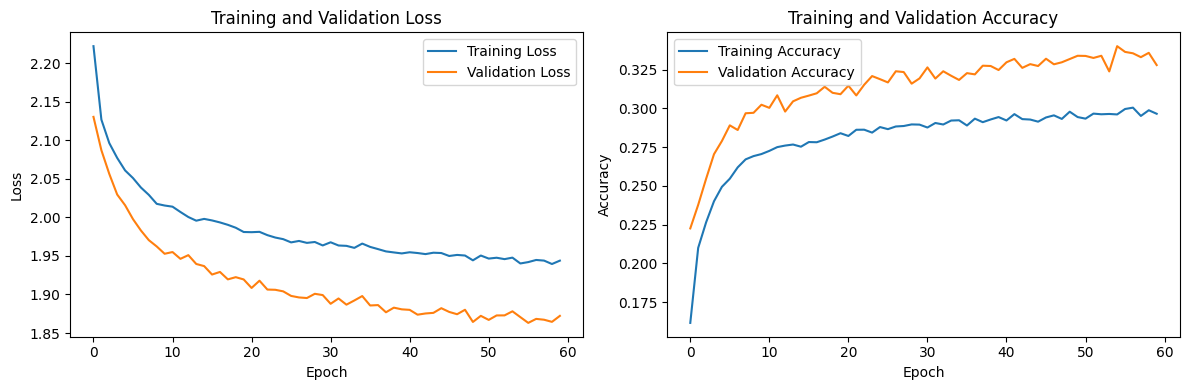

In [183]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

313/313 [==============================] - 0s 503us/step


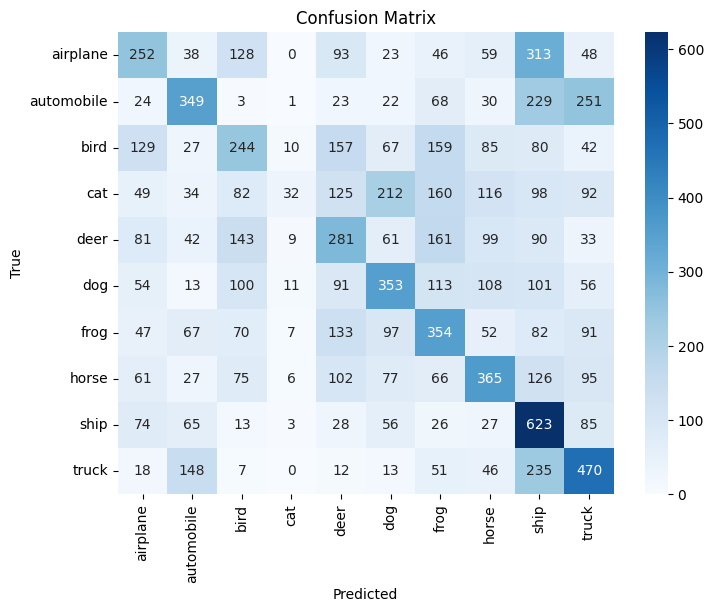

In [184]:
y_pred = np.argmax(model.predict(x_test_flat), axis=1)

y_true = np.argmax(y_test_one_hot, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

### Modelo CNN

In [185]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), name='conv1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='maxpool1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='maxpool2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', name='dense1'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax', name='output_layer')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 30, 30, 32)        320       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 15, 15, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 13, 13, 64)        18496     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 6, 6, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense1 (Dense)              (None, 128)               295040    
                                                                 
 dropout_6 (Dropout)         (None, 128)             

In [186]:
history_cnn = model_cnn.fit(
    x_train_gray, y_train_one_hot,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/50
625/625 [==============================] - 9s 14ms/step - loss: 1.8452 - accuracy: 0.3254 - val_loss: 1.5582 - val_accuracy: 0.4522
Epoch 2/50
625/625 [==============================] - 9s 15ms/step - loss: 1.5547 - accuracy: 0.4479 - val_loss: 1.3646 - val_accuracy: 0.5292
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 1.4268 - accuracy: 0.4976 - val_loss: 1.2470 - val_accuracy: 0.5661
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 1.3414 - accuracy: 0.5301 - val_loss: 1.2062 - val_accuracy: 0.5878
Epoch 5/50
625/625 [==============================] - 10s 16ms/step - loss: 1.2844 - accuracy: 0.5486 - val_loss: 1.1953 - val_accuracy: 0.5889
Epoch 6/50
625/625 [==============================] - 10s 17ms/step - loss: 1.2236 - accuracy: 0.5735 - val_loss: 1.1038 - val_accuracy: 0.6214
Epoch 7/50
625/625 [==============================] - 9s 15ms/step - loss: 1.1911 - accuracy: 0.5849 - val_loss: 1.0934 - val_accuracy: 0.61

In [190]:
test_loss, test_accuracy = model_cnn.evaluate(x_test_gray, y_test_one_hot)
print(test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 1.3247 - accuracy: 0.6736
0.6736000180244446


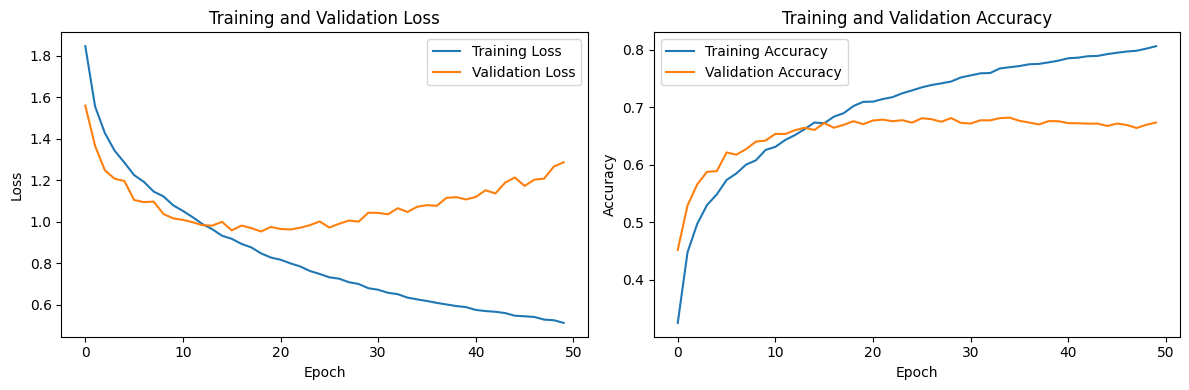

In [191]:
training_loss = history_cnn.history['loss']
validation_loss = history_cnn.history['val_loss']
training_accuracy = history_cnn.history['accuracy']
validation_accuracy = history_cnn.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 2ms/step


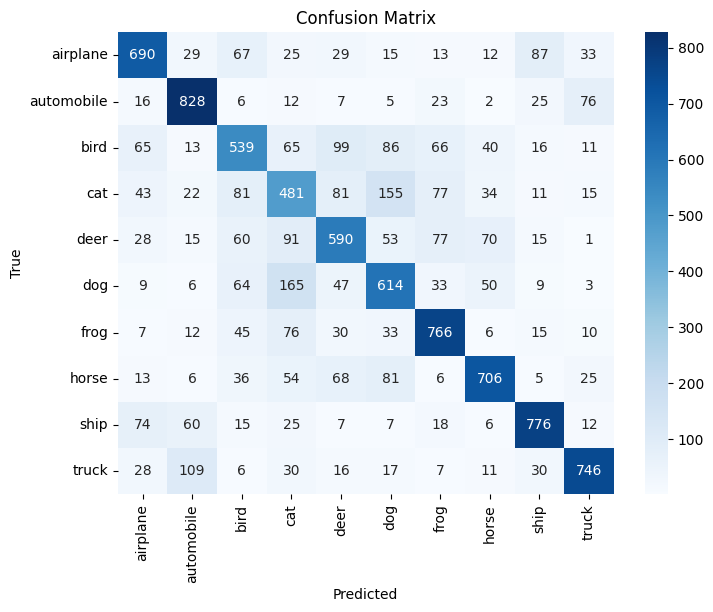

In [192]:
y_pred = np.argmax(model_cnn.predict(x_test_gray), axis=1)

y_true = np.argmax(y_test_one_hot, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

### CNN Transfer Learning

In [159]:
from tensorflow.keras.applications import ResNet50

In [157]:
# Pasamos al formato de resnet50

x_train_rgb = np.stack((x_train_gray,) * 3, axis=-1)
x_test_rgb = np.stack((x_test_gray,) * 3, axis=-1)

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_rgb, y_train_one_hot, test_size=0.2, random_state=42
)

In [160]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in resnet_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 352s 4us/step


In [161]:
model_resnet = tf.keras.Sequential([
    resnet_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [162]:
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [163]:
model_resnet.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_48 (Dense)            (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 10)                2570      
                                                                 
Total params: 24114826 (91.99 MB)
Trainable params: 527114 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [164]:
history_resnet = model_resnet.fit(
    x_train_split, y_train_split,
    epochs=10,
    batch_size=64,
    validation_data=(x_val_split, y_val_split)
)

Epoch 1/10
625/625 [==============================] - 50s 78ms/step - loss: 2.2842 - accuracy: 0.1249 - val_loss: 2.2003 - val_accuracy: 0.2007
Epoch 2/10
625/625 [==============================] - 48s 77ms/step - loss: 2.2128 - accuracy: 0.1472 - val_loss: 2.1393 - val_accuracy: 0.2238
Epoch 3/10
625/625 [==============================] - 50s 80ms/step - loss: 2.1818 - accuracy: 0.1636 - val_loss: 2.1101 - val_accuracy: 0.2336
Epoch 4/10
625/625 [==============================] - 51s 82ms/step - loss: 2.1558 - accuracy: 0.1762 - val_loss: 2.0767 - val_accuracy: 0.2497
Epoch 5/10
625/625 [==============================] - 52s 83ms/step - loss: 2.1409 - accuracy: 0.1801 - val_loss: 2.0210 - val_accuracy: 0.2670
Epoch 6/10
625/625 [==============================] - 53s 84ms/step - loss: 2.1268 - accuracy: 0.1866 - val_loss: 2.0146 - val_accuracy: 0.2701
Epoch 7/10
625/625 [==============================] - 52s 84ms/step - loss: 2.1240 - accuracy: 0.1904 - val_loss: 2.0397 - val_accuracy:

In [166]:
test_loss, test_accuracy = model_resnet.evaluate(x_test_rgb, y_test_one_hot)
print(test_accuracy)

313/313 [==============================] - 12s 37ms/step - loss: 2.0126 - accuracy: 0.3089
0.30889999866485596


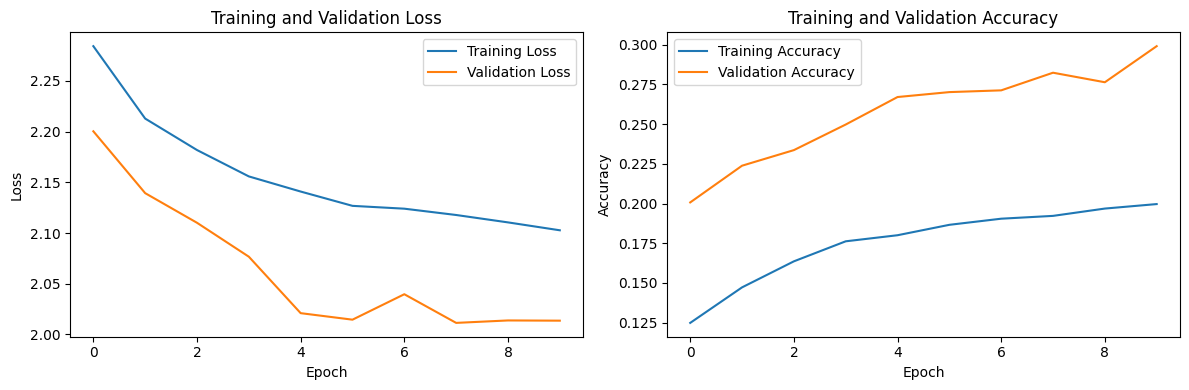

In [168]:
training_loss = history_resnet.history['loss']
validation_loss = history_resnet.history['val_loss']
training_accuracy = history_resnet.history['accuracy']
validation_accuracy = history_resnet.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [167]:
y_pred_resnet = np.argmax(model_resnet.predict(x_test_rgb), axis=1)
y_true_resnet = np.argmax(y_test_one_hot, axis=1)

313/313 [==============================] - 12s 38ms/step


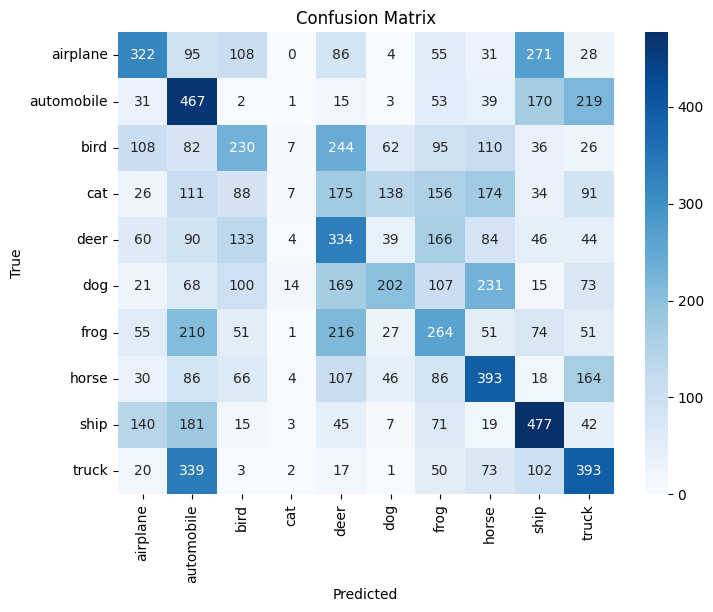

In [169]:
conf_matrix = confusion_matrix(y_true_resnet, y_pred_resnet)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

### Arquitectura compleja

In [193]:
model_complex_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [194]:
model_complex_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [195]:
history_complex_cnn = model_complex_cnn.fit(x_train_gray, y_train_one_hot, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 102s 324ms/step - loss: 1.7869 - accuracy: 0.4369 - val_loss: 4.5367 - val_accuracy: 0.1516
Epoch 2/20
313/313 [==============================] - 111s 356ms/step - loss: 1.1203 - accuracy: 0.6125 - val_loss: 1.2734 - val_accuracy: 0.5605
Epoch 3/20
313/313 [==============================] - 119s 379ms/step - loss: 0.9138 - accuracy: 0.6828 - val_loss: 0.9364 - val_accuracy: 0.6761
Epoch 4/20
313/313 [==============================] - 116s 370ms/step - loss: 0.8083 - accuracy: 0.7204 - val_loss: 0.8231 - val_accuracy: 0.7184
Epoch 5/20
313/313 [==============================] - 105s 336ms/step - loss: 0.7280 - accuracy: 0.7438 - val_loss: 0.7892 - val_accuracy: 0.7298
Epoch 6/20
313/313 [==============================] - 102s 327ms/step - loss: 0.6640 - accuracy: 0.7668 - val_loss: 0.8416 - val_accuracy: 0.7183
Epoch 7/20
313/313 [==============================] - 108s 346ms/step - loss: 0.6080 - accuracy: 0.7886 - val_loss: 0.7062 -

In [197]:
test_loss, test_accuracy = model_complex_cnn.evaluate(x_test_gray, y_test_one_hot)
print(test_accuracy)

313/313 [==============================] - 6s 19ms/step - loss: 0.7859 - accuracy: 0.7780
0.777999997138977


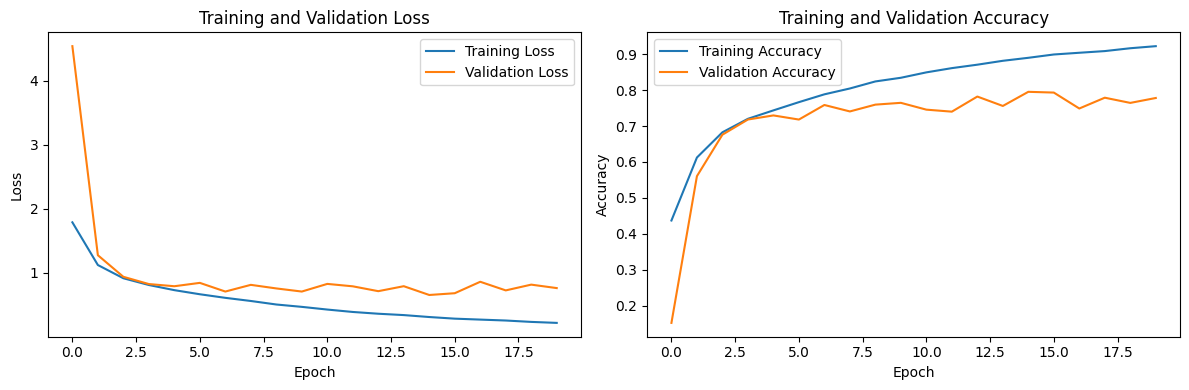

In [199]:
training_loss = history_complex_cnn.history['loss']
validation_loss = history_complex_cnn.history['val_loss']
training_accuracy = history_complex_cnn.history['accuracy']
validation_accuracy = history_complex_cnn.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 5s 17ms/step


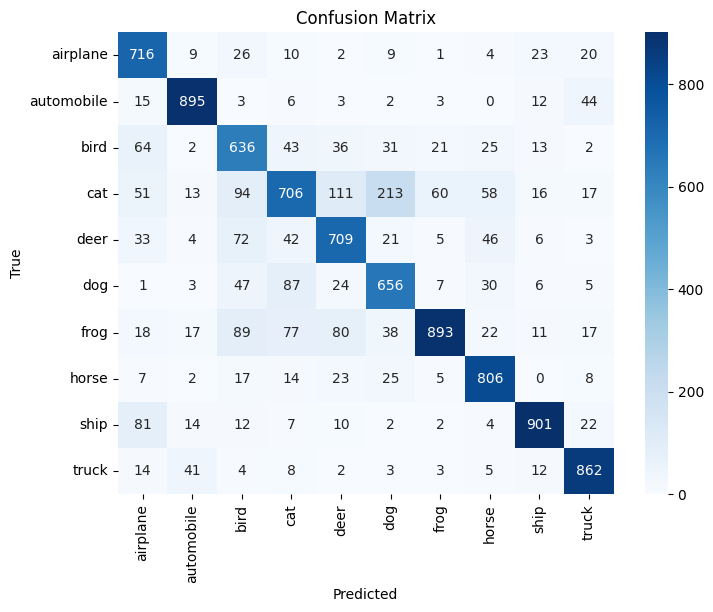

In [200]:
y_pred = np.argmax(model_complex_cnn.predict(x_test_gray), axis=1)

y_true = np.argmax(y_test_one_hot, axis=1)

conf_matrix = confusion_matrix(y_pred, y_true)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();